In [2]:
!pip install bs4

Processing c:\users\user\appdata\local\pip\cache\wheels\0a\9e\ba\20e5bbc1afef3a491f0b3bb74d508f99403aabe76eda2167ca\bs4-0.0.1-py3-none-any.whl


In [1]:
import os
import numpy as np
import pandas as pd
import re
import random
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

# seed 고정 함수
def seed_everything(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

seed_everything()

# 1. Data Loading

In [2]:
data = pd.read_csv("C:/Users/user/study/NLP_tutorial/dataset/Reviews.csv", nrows = 200000)

In [3]:
print(len(data))
print(data.columns)
data = data[['Text', 'Summary']]
print(data.head())

200000
Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
                                                Text                Summary
0  I have bought several of the Vitality canned d...  Good Quality Dog Food
1  Product arrived labeled as Jumbo Salted Peanut...      Not as Advertised
2  This is a confection that has been around a fe...  "Delight" says it all
3  If you are looking for the secret ingredient i...         Cough Medicine
4  Great taffy at a great price.  There was a wid...            Great taffy


In [14]:
data.sample(10)

,Text,Summary
182531,Kind Healthy Grains Vanilla Blueberry Clusters...,"Very crunchy, but a not as tasty as I expected"
40369,I got these for my kids lunch snacks - our sch...,Great Lunch Snack
179090,"I seldom write reviews, but this popcorn is so...",THIS POPCORN IS AMAZING!
86364,I like elderberry tea and this is a good tea t...,Wild Elderberry Tea
18440,"Ordered this for my mom's trick or treaters , ...",Nestle Assorted Miniatures
96188,Even though I (thought) I hated them for 25 ye...,You can definitely taste the salt & vinegar
185409,"Wow, the olive flavor socked me from the first...",Great flavor
154844,I used a lot of this mix adding all sorts of t...,Cake mix
166682,For a long time my one greyhound could not hav...,My hounds love these
79904,"And, if u do, use a fork! It's that easy! Bi...",U CAN't beat KRUSTEAZ!


# 2. Preprocessing & EDA
---
* 중복데이터 제거
* 결측치 제거
* 약어 처리 (뜻은 같은데 표기가 짧은 단어)
* 불용어 처리

<BR/>

* 데이터 길이분포 확인
* 모델링을 위해 문장길이 통일
  * 최대길이 설정하고 부족하면 패딩, 초과되면 관측삭제

In [16]:
# 중복값 확인
print("text 열 중 유일값 : ", data['Text'].nunique())
print("summary 열 중 유일값 : ", data['Summary'].nunique())

# summary문의 경우 문장자체가 매우 짧아 겹칠 수 있다고 가정. 원문(text)이 겹치는 경우만 솎아주기

text 열 중 유일값 :  162842
summary 열 중 유일값 :  128912


In [4]:
data.drop_duplicates(subset = ['Text'], inplace = True)
print("남은 전체 샘플수 :", len(data))

남은 전체 샘플수 : 162842


In [18]:
# 결측값 확인
data.isnull().sum()

Text       0
Summary    1
dtype: int64

In [5]:
# 결측값을 포함한 관측 제거
data.dropna(axis = 0, inplace = True)

In [20]:
print("남은 전체 샘플수 :", len(data))

남은 전체 샘플수 : 162841


In [6]:
# 동의어 처리를 위한 dictionary
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [7]:
# NLTK 불용어
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{'did', 'mustn', 'weren', 'if', "wouldn't", 'off', 'needn', 'in', 'between', "you'd", 'below', "weren't", 'other', 'how', 'o', 'them', 'was', 'not', 'by', "aren't", "mustn't", 'such', "that'll", 'few', 'own', "shan't", 'to', 'from', 'so', 'most', 'under', 'is', 'as', 'over', 'her', 'further', "should've", "doesn't", 'been', "hadn't", 'myself', 'an', 'into', 've', 'shan', "needn't", 'he', 'has', 'it', 'until', 'above', "couldn't", "shouldn't", 'because', 'during', 'while', 'at', 'd', "haven't", 'its', 'didn', 'aren', 'after', 'himself', 'hers', 'shouldn', "isn't", 'out', 'each', 'won', 'which', 'your', 'why', 'wouldn', 'isn', "wasn't", 'being', 'but', 'what', 'a', "didn't", 'about', 'having', 'my', 'y', 'than', 'hasn', 'should', 'theirs', 'who', 'yours', 'can', "you'll", 'we', 'ma', 'this', 'again', 'more', 'down', 'yourselves', 'before', 'will', 'our', 'for', "don't", 'the', 'have', 'all', 'or', 'very', 're', "you've", 'here', 'am', 'up', 'mightn', 'haven', 'couldn', 'ours

#### 전처리 함수 구축
> * 문장전체를 소문자화
* html 태그, 쌍따옴표, 소유격 제거
* 괄호로 닫힌 부분 문자열 제거
* 약어 정규화
* 숫자, 특수문자 등 알파벳 외의 문자를 공백으로 변환
* m이 3개 이상이면 2개로 변경 
* 불용어 처리 (원문에서만 제거)

In [8]:
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower()                                # 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text            # html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)              # 괄호로 닫힌 문자열 제거
    sentence = re.sub('"', '', sentence)                       # 쌍따옴표 제거
    # 약어 정규화
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b","",sentence)                     # 소유격 제거
    sentence = re.sub("[^a-zA-Z]", " ", sentence)              # 영어 외 문자(숫자, 특수문자) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence)               # m이 3개 이상이면 2개로 변경
    
    # 불용어 처리
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1) 
    return tokens

In [9]:
# example
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br /> for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))

everything bought great infact ordered twice third ordered mother father
great way to start the day


In [10]:
a = [1,2,3,4,5,6]
random.sample(a, 3)

[6, 1, 5]

In [11]:
# Text column 전처리
clean_text = []
for s in data['Text']:   # series도 순회가능
    clean_text.append(preprocess_sentence(s))
    
random.sample(clean_text, 5)

['plus good deal price love convenience free delivery subscribe save saves money son ate always stock stores online good buy like ounce size containers minuses son gets constipated rice cereal oatmeal much better uses much breast milk mixing together mix directions right consistency feed baby would buy one package first see child reacts rice buy pack like',
 'love coffee way need one machines bought first one years ago visiting relative recently bought second one motorhome yeah really like coffee way dependable easy clean',
 'work dollar general sell dollar walmart sells like either place buy saving money paying shipping overcharge',
 'finding delicious little packages fruit score perfect go snack apple apricot favorite flavor',
 'quaker oats staple family generations oatmeal maternal grandmother prepared although always used old fashioned oatmeal actually cooked alive today know would tried quaker instant oatmeal packets prepared according package directions oatmeal comes smooth lumps

In [12]:
# Summary column 전처리
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))

random.sample(clean_summary, 5)

C:\Users\user\anaconda3\envs\for_deep\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\user\anaconda3\envs\for_deep\lib\site-packages\bs4\__init__.py:282: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\user\anaconda3\envs\for_deep\lib\site-packages\bs4\__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Users\user\anaconda3\envs\for_deep\lib\site-packages\bs4\__init__.py:282: UserWarning: "http://www.amazon.

['fantastic',
 'excellent coffee',
 'the good reviews just mystify me',
 'great smell brown water',
 'good if you like flavored coffee']

In [13]:
# 전처리 결과를 데이터프레임에 다시 저장
data['Text'] = clean_text
data['Summary'] = clean_summary

In [50]:
# 전처리 이후 소멸되머린 샘플을 NAN으로 변환
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

# 해당 관측 제거
data.dropna(axis = 0, inplace = True)
print('남은 전체 샘플수 :',(len(data)))

Text         1
Summary    141
dtype: int64
남은 전체 샘플수 : 162699


텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.47853397992612
요약의 최소 길이 : 1
요약의 최대 길이 : 28
요약의 평균 길이 : 3.9920036386210116


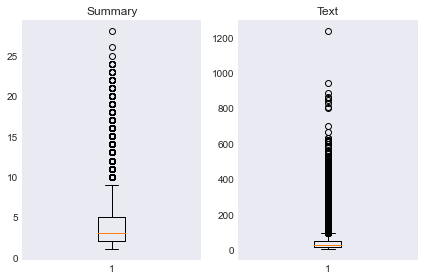

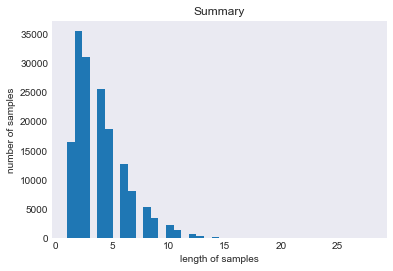

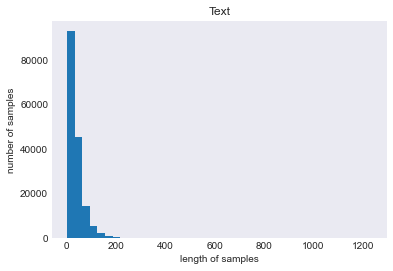

In [53]:
# EDA
plt.style.use("seaborn-dark")

# 원문과 요약문의 길이 분포
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
# 문장길이 통일을 위한 최대길이 설정
text_max_len = 50
summary_max_len = 8

def below_threshold_cnt(batch_data, threshold):
    li = [len(s.split()) for s in batch_data if len(s.split()) <= threshold]
    print('길이가 {}이상인 샘플의 비율 = {}'.format(threshold,len(li)/len(batch_data) ))

below_threshold_cnt(data['Text'], text_max_len)
below_threshold_cnt(data['Summary'], summary_max_len)

길이가 50이상인 샘플의 비율 = 0.7779797471152843
길이가 8이상인 샘플의 비율 = 0.9439883076129476


In [15]:
# 설정한 최대 길이 초과하는 관측들 삭제
# -- series.apply( lambda(x:f(x)) )  --- series를 x(input)로 취해서 f(x)를 계산한 결과를 반환 
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('남은 전체 샘플수 :',(len(data)))

남은 전체 샘플수 : 121930


# 3. Data Preparing for Training
* decoder의 input, target을 정의하기위해 sos, eos 토큰 추가
* 데이터 분리
* 단어사전 및 룩업테이블 생성
* empty samples 제거
* 패딩을 통해 시퀀스 길이맞추기

In [16]:
# summary 데이터에 sos 토큰과 eos 토큰을 추가
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')

encoder_input = np.array(data['Text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,not as advertised,sostoken not as advertised,not as advertised eostoken
2,confection around centuries light pillowy citr...,delight says it all,sostoken delight says it all,delight says it all eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [17]:
## train test split
# data shuffle
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# split
test_ratio = 0.2
test_size = int(len(indices)*test_ratio)

encoder_input_train = encoder_input[:-test_size]
decoder_input_train = decoder_input[:-test_size]
decoder_target_train = decoder_target[:-test_size]

encoder_input_test = encoder_input[-test_size:]
decoder_input_test = decoder_input[-test_size:]
decoder_target_test = decoder_target[-test_size:]


print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

[106142  79383 111053 ... 103694    860  15795]
훈련 데이터의 개수 : 97544
훈련 레이블의 개수 : 97544
테스트 데이터의 개수 : 24386
테스트 레이블의 개수 : 24386


### Encoding

In [18]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [33]:
# src_tokenizer.word_index : 파싱된 단어 각각이 정수에 맵핑된 dictionary
# src_tokenizer.word_counts : 파싱된 단어 각각의 말뭉치 내 등장횟수
threshold = 3
n_tot_words = len(src_tokenizer.word_index)
n_rare_words = 0
tot_freq = 0
rare_freq = 0

# 단어 / 빈도 순회
for key, value in src_tokenizer.word_counts.items():
    tot_freq = tot_freq + value

    # 말뭉치 내 등장 횟수가 임계값 이하인 단어들 count
    if(value <= threshold):
        n_rare_words = n_rare_words + 1
        rare_freq = rare_freq + value

print('vocabulary 크기 :',n_tot_words)
print(f'등장 빈도가 {threshold}번 이하인 단어의 수: {n_rare_words}')
print("희귀 단어 비율:", (n_rare_words / n_tot_words)*100)
print("희귀 단어 출현 비율:", (rare_freq / tot_freq)*100)

vocabulary 크기 : 44047
등장 빈도가 3번 이하인 단어의 수: 28981
희귀 단어 비율: 65.79562739800667
희귀 단어 출현 비율: 1.6857224744230799


> * Q1) 전체 vocabulary에서 희귀단어를 제외하여 truncate 하였는데 아래와 같이 남은 단어보다 더 작은 수를 num_words로 지정할 경우 나머지단어들은 어캐되는거? 빈도수 순으로 짤린다는데, 빈도수가 같으면 알파벳순으로 짤리는건가? -> 그런듯
* Q2) train set으로 토크나이저를 fit하여 룩업테이블을 얻었는데, 이 경우 test input에만 있고 train input에는 없는 단어가 나올경우 어캐처리??

In [34]:
src_vocab = 15000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

> 변환된 데이터셋은 수치 레이블(단어 id)을 담은 이중 리스트가 되며,<br/>
어휘사전에 포함되어있지 않은 단어들이 등장할 경우 변환 후 시퀀스에 해당단어들은 제외된다.<br/><br/>
토크나이저에 OOB샘플을 따로 매핑하도록 할 수는 없을까?

In [38]:
# 타겟 시퀀스(요약문)에 대해서도 동일한 작업 수행
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 3
n_tot_words = len(tar_tokenizer.word_index)
n_rare_words = 0
tot_freq = 0
rare_freq = 0

# 단어 / 빈도 순회
for key, value in tar_tokenizer.word_counts.items():
    tot_freq = tot_freq + value

    # 말뭉치 내 등장 횟수가 임계값 이하인 단어들 count
    if(value <= threshold):
        n_rare_words = n_rare_words + 1
        rare_freq = rare_freq + value

print('vocabulary 크기 :',n_tot_words)
print(f'등장 빈도가 {threshold}번 이하인 단어의 수: {n_rare_words}')
print("희귀 단어 비율:", (n_rare_words / n_tot_words)*100)
print("희귀 단어 출현 비율:", (rare_freq / tot_freq)*100)

vocabulary 크기 : 14685
등장 빈도가 3번 이하인 단어의 수: 10118
희귀 단어 비율: 68.90023833844059
희귀 단어 출현 비율: 3.2310053722179584


In [40]:
tar_vocab = 4000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

### delete empty samples

In [43]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 1540
삭제할 테스트 데이터의 개수 : 434


In [45]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('남은 훈련 데이터의 개수 :', len(encoder_input_train))
print('남은 테스트 데이터의 개수 :',len(encoder_input_test))

남은 훈련 데이터의 개수 : 96004
남은 테스트 데이터의 개수 : 23952


### Padding

In [46]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

# 4. Training Model 
---
seq2seq + attention

In [47]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [52]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [53]:
embedding_dim = 200
hidden_size = 300

# encoder
encoder_inputs = Input(shape = (text_max_len, ))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

enc_lstm1 = LSTM(hidden_size, return_sequences = True, return_state = True, 
                 dropout = 0.4, recurrent_dropout = 0.4)
enc_output1, state_h1, state_c1 = enc_lstm1(enc_emb)
enc_lstm2 = LSTM(hidden_size, return_sequences = True, return_state = True, 
                 dropout = 0.4, recurrent_dropout = 0.4)
enc_output2, state_h2, state_c2 = enc_lstm2(enc_output1)
enc_lstm3 = LSTM(hidden_size, return_sequences = True, return_state = True, 
                 dropout = 0.4, recurrent_dropout = 0.4)
enc_outputs, state_h, state_c = enc_lstm3(enc_output2)

# decoder
decoder_inputs = Input(shape = (None, ))
dec_emb = Embedding(tar_vocab, embedding_dim)(decoder_inputs)


dec_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, 
                    dropout = 0.4, recurrent_dropout=0.2)
dec_outputs, _, _ = dec_lstm(dec_emb, initial_state = [state_h, state_c])

# ------------------------------------------------ 일반적인 출력층
# # output of decoder
# dec_softmax_layer = Dense(tar_vocab, activation = 'softmax')
# dec_softmax_outputs = dec_softmax_layer(dec_outputs) 

# # model define
# model = Model([encoder_inputs, decoder_inputs], dec_softmax_outputs)
# model.summary()
# ------------------------------------------------ 어텐션 이용 출력층
# attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([enc_outputs, dec_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
dec_concat_output = Concatenate(axis = -1, name='concat_layer')([dec_outputs, attn_out])

# 디코더의 출력층
dec_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = dec_softmax_layer(dec_concat_output)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 50, 200)      3000000     input_5[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 50, 300), (N 601200      embedding_4[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [54]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], 
                    y = decoder_target_train,
                    validation_data = ([encoder_input_test, decoder_input_test],decoder_target_test),
                    batch_size = 256, callbacks = [es], epochs = 50)

Train on 96004 samples, validate on 23952 samples
Epoch 1/50
96004/96004 [==============================] - 8748s 91ms/sample - loss: 2.7379 - val_loss: 2.5011
Epoch 2/50
96004/96004 [==============================] - 5533s 58ms/sample - loss: 2.3680 - val_loss: 2.2660
Epoch 3/50
96004/96004 [==============================] - 5640s 59ms/sample - loss: 2.2050 - val_loss: 2.1671
Epoch 4/50
25344/96004 [======>.......................] - ETA: 1:02:00 - loss: 2.1170WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss


KeyboardInterrupt: 

In [55]:
model.save("C:/Users/user/study/NLP_tutorial/saved_model/enc_dec_epoch3.h5")

In [57]:
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='valid')
# plt.legend()
# plt.show()

# 5. Inference
encoder-decoder network에서 decoder의 behavior가 train시와 test시에 다르기 때문에 <br/>
별도로 모델을 설계할 수 있다.
> inference(test) 시에는 target sequence가 주어지지 않기때문에 sostoken만 인풋으로 받고<br/>
각 시점의 출력을 이후 시점의 input으로 가져간다.<br/>
또한 훈련시와는 다르게 디코더의 매시점 state vector들을 버리지 않고 이후 시점 input으로 사용한다.

In [58]:
# encoder 
encoder_model = Model(inputs=encoder_inputs, outputs=[enc_outputs, state_h, state_c])

# decoder
# 디코더의 이전시점 상태벡터(h, c)들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb2 = dec_emb_layer(decoder_inputs)

decoder_outputs2, state_h2, state_c2 =\
    dec_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# attention function
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# final output
decoder_outputs2 = dec_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [59]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 숫자 -> 텍스트

In [60]:
# 필요한 딕셔너리 정의
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [61]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [62]:
for i in range(10):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("정답 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

# 3에폭 성능 실화냐

원문 :  use treats put kong toys give three labs something work leave work love especially like lamb salmon flavor nice soft treats break half make last longer 
정답 요약문 : great treats for treat toys 
예측 요약문 :  my my my for for


원문 :  chips unbelievably good favorite salt pepper vinegar sea salt come close second taste like potato chips potato flavor greasy filled fat bland taste like cardboard recommended chips weight watchers group local organic store cannot keep demand hit guilt free snack lots flavor thank popchips 
정답 요약문 : awesome chips 
예측 요약문 :  popcorn chips chips chips chips chips


원문 :  quick easy buying much easier going store mention convenient 
정답 요약문 : love this stuff 
예측 요약문 :  great and and to


원문 :  coins hard take day half chew anise flavor licorice thing candy sweet comes adorable coin shapes great candy idea flavor texture need lot improvement 
정답 요약문 : cute terrible taste 
예측 요약문 :  of to sugar the in


원문 :  used excellent kefir starter decades delicious consistan